Algoritmos

In [1]:
# @title Record
#Abstract Record
class Record:
  def __init__(self, record_size, value=None):
    self.byte_array = bytearray([0] * record_size)
    self.write(value)

  # creates a record from a bytearray
  def create(record_size, byte_array):
   raise NotImplementedError("Subclasses must implement create")

  def write(self, value):
    raise NotImplementedError("Subclasses must implement write")

  def read(self):
   raise NotImplementedError("Subclasses must implement read")

  def size(self):
    return len(self.byte_array)

  def bytes(self):
    return self.byte_array.copy()

  def __str__(self):
    return f"value:{self.read()}, capacity:{self.size()}"

In [3]:
# @title IndexEntry
import struct
class IndexEntry(Record):

  def __init__(self, record_size, age, pageId):
    self.byte_array = bytearray([0] * record_size)
    self.write(age, pageId)

  def create(record_size, byte_array):
    (age, pageId) = IndexEntry.__unpack(byte_array)
    return IndexEntry(record_size, age, pageId)

  def write(self, age, pageId):
    if(not isinstance(age, int) or not isinstance(pageId, int)):
       raise TypeError(f"The key and pageId must be int!")

    self.byte_array[:4] = struct.pack('I', age)
    self.byte_array[4:8] = struct.pack('I', pageId)


  def read(self):
    return IndexEntry.__unpack(self.byte_array)

  def __unpack(byte_array):
    age = struct.unpack('I', byte_array[0:4])[0]
    pageId = struct.unpack('I', byte_array[4:8])[0]

    return (age, pageId)

In [4]:
# @title IndexEntry Test
rec = IndexEntry(8, 46, 1)
print(f"Bytes: {rec.bytes()}")
rec2 = IndexEntry.create(8, rec.bytes())
print(rec2)

Bytes: bytearray(b'.\x00\x00\x00\x01\x00\x00\x00')
value:(46, 1), capacity:8


In [6]:
# @title DataEntry
import struct
class DataEntry(Record):

  def __init__(self, record_size, name, age):
    self.byte_array = bytearray([0] * record_size)
    self.write(name, age)

  def create(record_size,byte_array):
    (name, age) = DataEntry.__unpack(byte_array)
    return DataEntry(record_size, name, age)

  def write(self, name, age):
    if(not isinstance(name, str) or not isinstance(age, int)):
       raise TypeError(f"The name must be str and age must be int!")

    self.byte_array[:4] = struct.pack('I', age)

    string_bytes = name.encode('utf-8')

    if (5+len(string_bytes))> len(self.byte_array):
      raise ValueError(f"Record overflow!")

    self.byte_array[4] = len(string_bytes)
    self.byte_array[5:5+len(string_bytes)] = string_bytes


  def read(self):
    return DataEntry.__unpack(self.byte_array)

  def __unpack(byte_array):
    age = struct.unpack('I', byte_array[0:4])[0]
    string_bytes = byte_array[5:5+byte_array[4]]
    return (string_bytes.decode('utf-8'), age)

In [7]:
# @title DataEntry test
rec = DataEntry(10,"João", 46)
print(rec)
print(f"Bytes: {rec.bytes()}")
rec2 = DataEntry.create(10, rec.bytes())
print(rec2)

value:('João', 46), capacity:10
Bytes: bytearray(b'.\x00\x00\x00\x05Jo\xc3\xa3o')
value:('João', 46), capacity:10


In [8]:
# @title Block
import struct

class Block:
  def __init__(self, block_size, record_size):
    self.records = []
    self.block_size = block_size
    self.record_size = record_size
    self.capacity = (block_size-2) // record_size #two bytes are used to store the number or records

  # creates a block from a bytearray
  def create(block_size, record_size, byte_array, Record):
    block = Block(block_size, record_size)

    num_records = struct.unpack('>H', byte_array[:2])[0]
    pos = 2
    for _ in range(num_records):
      rec = Record.create(record_size, byte_array[pos:pos+record_size] )
      block.add(rec)
      pos += record_size

    return block

  def add(self, record):
    if(self.size() < self.capacity):
      self.records.append(record)
    else:
      raise ValueError("The block is full!")

  def addIndex(self, index, record):
    if(self.size() < self.capacity):
      self.records.insert(index, record)
    else:
      raise ValueError("The block is full!")

  def remove(self, keyPos, keyValue):
    if(not isinstance(keyPos, int)):
       raise TypeError(f"The keyPos must be an int!")

    rec = self.search(keyPos, keyValue)
    if(rec):
      return self.records.remove(rec)
    return None

  def removeIndex(self, index):
    if(not isinstance(index, int)):
       raise TypeError(f"The index must be int!")
    return self.records.pop(index)

  def removeLast(self):
    if len(self.records)>0:
      return self.records.pop()
    return None

  def read(self):
    str=""
    for rec in self.records:
      str += f"{rec.read()}\n"
    return str;

  #returns the position of the record within the block
  def search(self, keyPos, keyValue):
    if(not isinstance(keyPos, int)):
       raise TypeError(f"The key must be an int!")

    for i in range(len(self.records)):
      if(self.getRecord(i).read()[keyPos]==keyValue):
        return i
    return -1

  # returns the list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyPos, keyValueA, keyValueB):
    if(not isinstance(keyPos, int)):
       raise TypeError(f"The keyPos must be an int!")

    ret = []
    for rec in self.records:
      recValue = rec.read()[keyPos]
      if(recValue>=keyValueA and recValue<keyValueB):
        ret.append(rec)
    return ret

  def getRecord(self, index):
    return self.records[index]

  def getFirtRecord(self):
    return self.records[0]

  def getLastRecord(self):
    return self.records[-1]

  def size(self):
    return len(self.records)

  def isFull(self):
    return self.size()==self.capacity

  def isEmpty(self):
    return self.size()==0

  def bytes(self):
    byte_array = bytearray([0] * self.block_size)

    byte_array[:2] = struct.pack('>H', self.size()) #pack int into two bytes
    pos = 2
    for rec in self.records:
      byte_array[pos:pos+rec.size()] = rec.bytes()
      pos += rec.size()

    return byte_array

In [9]:
# @title Block test
indexBlock = Block(64, 8)
print(f"block capacity: {indexBlock.capacity}")
print(f"block size: {indexBlock.size()}")

indexBlock.add(IndexEntry(8, 46, 1))
indexBlock.add(IndexEntry(8, 33, 1))
indexBlock.add(IndexEntry(8, 28, 2))


print(indexBlock.read())

print(f"getRecord(0): {indexBlock.getRecord(0)}")
print(f"search: {indexBlock.search(0, 33)}")
print(f"range search(0, 28, 40):")
for rec in indexBlock.rangeSearch(0, 28, 40):
  print(rec)
print(f"block bytes: {indexBlock.bytes()}")

block2 = Block.create(64, 8, indexBlock.bytes(), IndexEntry)
print(block2.read())

dataBlock = Block(64, 12)
print(f"block capacity: {dataBlock.capacity}")
print(f"block size: {dataBlock.size()}")

dataBlock.add(DataEntry(12, "Ana", 28))
dataBlock.add(DataEntry(12, "Dade", 33))
dataBlock.add(DataEntry(12, "Felix", 17))


print(dataBlock.read())

print(f"getRecord(0): {dataBlock.getRecord(0)}")
print(f"search: {dataBlock.search(1, 33)}")
print(f"range search(1, 28, 30):")
for rec in dataBlock.rangeSearch(1, 28, 30):
  print(rec)
print(f"block bytes: {dataBlock.bytes()}")

block2 = Block.create(64, 12, dataBlock.bytes(), DataEntry)
print(block2.read())

block capacity: 7
block size: 0
(46, 1)
(33, 1)
(28, 2)

getRecord(0): value:(46, 1), capacity:8
search: 1
range search(0, 28, 40):
value:(33, 1), capacity:8
value:(28, 2), capacity:8
block bytes: bytearray(b'\x00\x03.\x00\x00\x00\x01\x00\x00\x00!\x00\x00\x00\x01\x00\x00\x00\x1c\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
(46, 1)
(33, 1)
(28, 2)

block capacity: 5
block size: 0
('Ana', 28)
('Dade', 33)
('Felix', 17)

getRecord(0): value:('Ana', 28), capacity:12
search: 1
range search(1, 28, 30):
value:('Ana', 28), capacity:12
block bytes: bytearray(b'\x00\x03\x1c\x00\x00\x00\x03Ana\x00\x00\x00\x00!\x00\x00\x00\x04Dade\x00\x00\x00\x11\x00\x00\x00\x05Felix\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
('Ana', 28)
('Dade', 33)
('Felix', 17)



In [10]:
# @title HeapFile
import os


class HeapFile:

  def __init__(self, filename, block_size, record_size, Record, recordKeyId, create=False):
    self.filename = filename
    self.block_size = block_size
    self.record_size = record_size
    self.Record = Record
    self.keyPos = recordKeyId

    #print(f"os.path.abspath(filename): {os.path.abspath(filename)}")

    if(create and os.path.exists(filename)):
      os.remove(filename)

    if((not create) and os.path.exists(filename)):
      self.blocks = os.path.getsize(filename)//block_size
    else:
      if(os.path.exists(filename)):
        os.remove(filename)

      self.blocks = 1
      with open(self.filename, "wb") as file:
        file.write(Block(block_size, record_size).bytes())

  def add(self, record):
    block = self.read(self.blocks-1)

    if(block.isFull()):
      self.blocks+=1
      block = Block(self.block_size, self.record_size)

    block.add(record)
    self.write(self.blocks-1, block)

  def addNewBlock(self):
    block = Block(self.block_size, self.record_size)
    self.write(self.blocks, block)
    self.blocks+=1

  def remove(self, key):
    (block_id, rec_id) = self.search(key)
    if block_id>=0:
      block = self.read(block_id)
      block.removeIndex(rec_id)
      self.write(block_id, block)

  def scan(self, output=True):
    for i in range(self.blocks):
      if output:
        print(self.read(i).read())
      else:
        self.read(i).read()

  # returns the record, containing the key
  def search(self, key):
    for i in range(self.blocks):
      block = self.read(i)
      rec_id = block.search(self.keyPos, key)

      if(rec_id>=0):
        return (i, rec_id)
    return (-1, -1)

  # returns a list of records, within the range keyA (inclusive) and KeyB (exclusive)
  def rangeSearch(self, keyA, keyB):
    result = []
    for i in range(self.blocks):
      result += self.read(i).rangeSearch(self.keyPos, keyA, keyB)
    return result

  def write(self, block_id, block):
    if(not isinstance(block, Block)):
       raise TypeError(f"The block must by of Block type!")

    with open(self.filename, "r+b") as file:
      file.seek(self.block_size * (block_id))
      file.write(block.bytes())

  def readFirst(self):
    return self.read(0)

  def readLast(self):
    return self.read(self.blocks-1)

  def read(self, block_id):
    with open(self.filename, "r+b") as file:
      file.seek(self.block_size *(block_id))
      byte_array = file.read(self.block_size)
      return Block.create(self.block_size, self.record_size, byte_array, self.Record)

  


  def gracejoin(self, S, R):
    pass 



In [11]:
# @title HeapFile test
filename  = "heapfile.bin"
fileType = HeapFile(filename, 64, 12, DataEntry, 1)
fileType.add(DataEntry(12, "V1", 18))
fileType.add(DataEntry(12, "V2", 28))
fileType.add(DataEntry(12, "V3", 32))
fileType.add(DataEntry(12, "V5", 56))
fileType.add(DataEntry(12, "V6", 81))
fileType.add(DataEntry(12, "V7", 14))
fileType.add(DataEntry(12, "V8", 17))

fileType.scan()

print(f"blocks:{fileType.blocks}")

block1 = fileType.readFirst()
print(f"block1.getRecord(0)={block1.getRecord(0)}")

block2 = fileType.readLast()
print(f"block2.getRecord(1)={block2.getRecord(1)}")

print(f"range search(18, 32):")
for rec in fileType.rangeSearch(18, 32):
  print(rec)



os.remove(filename)

('V1', 18)
('V2', 28)
('V3', 32)
('V5', 56)
('V6', 81)

('V7', 14)
('V8', 17)

blocks:2
block1.getRecord(0)=value:('V1', 18), capacity:12
block2.getRecord(1)=value:('V8', 17), capacity:12
range search(18, 32):
value:('V1', 18), capacity:12
value:('V2', 28), capacity:12


In [31]:
NUMBER_OF_BUCKETS = 5
BUFFER_SIZE = 1

class Partition:
  def __init__(self,heapFile, number_of_buckets):   
    self.buckets = []
    self.heapFile = heapFile
    self.partitions = []  
        
    self.filenames = []
    for i in range(number_of_buckets):
        self.buckets.append([])
        partition = HeapFile('partition__'+heapFile.filename+'__'+str(i), heapFile.block_size, heapFile.record_size, DataEntry, heapFile.keyPos)
        self.partitions.append(partition)
        
    for blockIndex in range(heapFile.blocks):
        block = heapFile.read(blockIndex)
        block_size = block.size()
        for recordIndex in range(block_size):
            record = block.getRecord(recordIndex)
            bucket = self.hashAndGetBucket(record)
            self.partitions[bucket].add(record)
  
  def scan(self):
    for i in range(len(self.partitions)):
        print(f"Partition {i}:")
        for blockIndex in range(self.partitions[i].blocks):
            block = self.partitions[i].read(blockIndex)
            for recordIndex in range(block.size()):
                record = block.getRecord(recordIndex)
                print(f"{record.read()}")         
            
#   def add(self, dataEntry):
#     pass
    
  def hashing(self, dataEntry):
    data = dataEntry.read()
    return 7 * data[self.heapFile.keyPos] + 1

  def hashAndGetBucket(self, dataEntry):
    hashData = self.hashing(dataEntry)
    return hashData % NUMBER_OF_BUCKETS
        

In [ ]:
def gracejoin(S, R, number_of_buckets=3):
    

In [32]:
## Grace Join Test ##

S = HeapFile("S.bin", 48, 12, DataEntry, 1)
S.add(DataEntry(12, "S1", 18))
S.add(DataEntry(12, "S3", 32))
S.add(DataEntry(12, "S4", 26))
S.add(DataEntry(12, "S8", 32))

partition = Partition(S, NUMBER_OF_BUCKETS)

partition.scan()
# R = HeapFile("R.bin", 48, 12, DataEntry, 1)
# R.add(DataEntry(12, "R1", 18))
# R.add(DataEntry(12, "R2", 28))
# R.add(DataEntry(12, "R3", 32))
# R.add(DataEntry(12, "R5", 56))
# R.add(DataEntry(12, "R6", 81))
# R.add(DataEntry(12, "R7", 14))
# R.add(DataEntry(12, "R8", 32))
# R.add(DataEntry(12, "R9", 17))

# gracejoin(S, R)

Partition 0:
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 32)
('S3', 32)
('S8', 3

In [12]:
# @title SortedFile
import os
class SortedFile(HeapFile):

  def add(self, record):
    (block_id, rec_id) = self.__internalSearch(record.read()[self.keyPos])

    if rec_id == -1:
      rec_id = 0

    block = self.read(block_id)

    #find the right block and position to start inserting the record in the blocks
    while rec_id < block.size() and block.getRecord(rec_id).read()[self.keyPos] < record.read()[self.keyPos]:
      rec_id+=1
      if rec_id>= block.capacity:
        rec_id = 0
        block_id += 1
        if block_id < self.blocks:
          block = self.read(block_id)
        else:
          self.blocks+=1
          block = Block(self.block_size, self.record_size)
          self.write(self.blocks-1, block)
          break

    #insert the record in the right block, propagating the insertion
    while block_id < self.blocks:
      block = self.read(block_id)

      if block.isFull():
        rec = block.removeLast()
      else:
        rec = None

      block.addIndex(rec_id, record)
      self.write(block_id, block)

      if(rec):
        record = rec
      else:
        break

      rec_id = 0
      if not block.isFull():
        block.add(rec)
        self.write(block_id, block)
      else:
        if (block_id+1) >= self.blocks:
          self.blocks+=1
          block = Block(self.block_size, self.record_size)
          self.write(self.blocks-1, block)
      block_id+=1

  def remove(self, key):
    ret = None
    (block_id, rec_id) = self.search(key)
    if block_id>=0:
      block = self.read(block_id)
      ret = block.removeIndex(rec_id)
      while (block_id + 1) <self.blocks:
        next_block = self.read(block_id+1)
        if next_block.isEmpty(): #the block is empty
          break;
        ##add the first of next_block
        block.add(next_block.removeIndex(0))
        self.write(block_id, block)

        block_id += 1
        block = next_block

      if(block.isEmpty()):
        self.blocks -= 1
      else:
        self.write(block_id, block)
    return ret

  def search(self, key):
    left = 0
    right = self.blocks-1

    while left <= right:
      mid = (left+right)//2
      block = self.read(mid)

      rec_id = block.search(self.keyPos, key)
      if(rec_id>=0):
        return (mid, rec_id)

      ref = block.getRecord(0).read()
      if key < ref[self.keyPos]:
        right = mid-1
      else:
        left = mid+1

    return (-1, -1)

  def rangeSearch(self, keyA, keyB):
    result = []
    (block_id, rec_id) = self.__internalSearch(keyA)

    if rec_id == -1:
      rec_id = 0

    if(block_id>=0):
      block = self.read(block_id)

      while block.getRecord(rec_id).read()[self.keyPos]< keyB:

        if block.getRecord(rec_id).read()[self.keyPos] >= keyA:
          result.append(block.getRecord(rec_id).read())

        rec_id+=1
        if rec_id>= block.size():
          rec_id = 0
          block_id += 1
          if block_id < self.blocks:
            block = self.read(block_id)
          else:
            break

    return result

  def __internalSearch(self, key):
    left = 0
    right = self.blocks-1
    mid = -1

    while left <= right and mid != (left+right)//2:
      mid = (left+right)//2
      block = self.read(mid)

      rec_id = block.search(self.keyPos, key)
      if(rec_id>=0):
        return (mid, rec_id)

      if block.size()>0:
        ref = block.getRecord(0).read()
      else:
        break

      if key < ref[self.keyPos]:
        right = mid
      else:
        left = mid

    return (mid, -1)


In [13]:
# @title SortedFile test
filename  = "sortedfile.bin"
fileType = SortedFile(filename, 48, 12, DataEntry, 1, True)

fileType.add(DataEntry(12, "V08", 17))
fileType.add(DataEntry(12, "V03", 32))
fileType.add(DataEntry(12, "V10", 18))
fileType.add(DataEntry(12, "V07", 14))
fileType.add(DataEntry(12, "V02", 28))
fileType.add(DataEntry(12, "V06", 81))
fileType.add(DataEntry(12, "V05", 56))
fileType.add(DataEntry(12, "V09", 22))
fileType.add(DataEntry(12, "V01", 16))
fileType.add(DataEntry(12, "V04", 33))

fileType.add(DataEntry(12, "V12", 15))
fileType.add(DataEntry(12, "V13", 44))
fileType.add(DataEntry(12, "V14", 46))
fileType.add(DataEntry(12, "V17", 39))
fileType.add(DataEntry(12, "V18", 40))


fileType.scan()

print(f"Searcing 18: {fileType.search(18)}")

print(f"Searcing 44: {fileType.search(44)}")

print(f"Searcing 81: {fileType.search(81)}")

print(f"range search(18, 30):")
for rec in fileType.rangeSearch(18, 30):
  print(rec)

#os.remove(filename)

('V07', 14)
('V12', 15)
('V01', 16)

('V08', 17)
('V10', 18)
('V09', 22)

('V02', 28)
('V03', 32)
('V04', 33)

('V17', 39)
('V18', 40)
('V13', 44)

('V14', 46)
('V05', 56)
('V06', 81)

Searcing 18: (1, 1)
Searcing 44: (3, 2)
Searcing 81: (4, 2)
range search(18, 30):
('V10', 18)
('V09', 22)
('V02', 28)


In [14]:
# @title ISAM
import os, json
class ISAM:

  def __init__(self, sortedFile, index_block_size, Record, recordSize, create=False):
    self.sortedFile = sortedFile
    self.height = 0
    indexFileName = sortedFile.filename + "_idx"
    propertyFileName = indexFileName + "_json"

    if((not create) and os.path.exists(indexFileName)):
      fileType = HeapFile(filename, 64, 12, DataEntry, 1)
      self.indexFile = HeapFile(indexFileName, index_block_size, recordSize, Record, 0)
      with open(propertyFileName, 'r') as json_file:
        index_prop = json.load(json_file)
      self.height =  index_prop["height"]
    else:
      if os.path.exists(indexFileName):
        os.remove(indexFileName)
        os.remove(propertyFileName)

      self.indexFile = self.__createIndex(indexFileName, sortedFile, index_block_size, Record, recordSize)
      index_prop = {'height': self.height}
      with open(propertyFileName, 'w') as json_file:
         json.dump(index_prop, json_file)

  # returns the page id and record position
  def search(self, key):

#     isamBlock = self.indexFile.readLast()
    nextBlockIndex = self.indexFile.blocks - 1
    lastBlockIndex = self.indexFile.blocks - 1
#     print(f"Last Block Index: {lastBlockIndex}")
    for blockIndex in range(lastBlockIndex, lastBlockIndex - (self.height + 1), -1):
#         print(f"Reading Block: {nextBlockIndex}")
        isamBlock = self.indexFile.read(nextBlockIndex)
        
        for recordIndex in range(isamBlock.size()):
            record = isamBlock.getRecord(recordIndex).read()
            if key <= record[0]:
#                 print(f"Record: {record}, Going to page: {record[1]}")
                nextBlockIndex = record[1]
                break
                
            if recordIndex == isamBlock.size() - 1:
                nextBlockIndex = -1
        
        if nextBlockIndex == -1:            
            return (-1, -1)
#     print(f"Reading Block: {nextBlockIndex}")

    leafBlock = self.sortedFile.read(nextBlockIndex)
    
    for i in range(leafBlock.size()):
        if key == leafBlock.getRecord(i).read()[self.sortedFile.keyPos]:
            return nextBlockIndex, i
    
    return (-1, -1)
            
            
        
        
    
            
        
        

  # returns a list of records, within the range lowKey (inclusive) and highKey (exclusive)
  def rangeSearch(self, lowKey, highKey):
    lowKeySearchResult = self.__search(lowKey)
    highKeySearchResult = self.__search(highKey)

    lastBlockIndex = highKeySearchResult[0] + 1
    
    if lowKeySearchResult[0] == -1:
        return []
    
    if highKeySearchResult[0] == -1:
        lastBlockIndex = self.sortedFile.blocks
    
    result = []
    for blockIndex in range(lowKeySearchResult[0], lastBlockIndex):
        currentBlock = self.sortedFile.read(blockIndex)
        for recordIndex in range(currentBlock.size()):
            recordKey = currentBlock.getRecord(recordIndex).read()
            if recordKey[self.sortedFile.keyPos] >= lowKey and recordKey[self.sortedFile.keyPos] < highKey:
                result.append(recordKey)
                
    return result

  # returns the page id and record position
  def __search(self, key):

#     isamBlock = self.indexFile.readLast()
    nextBlockIndex = self.indexFile.blocks - 1
    lastBlockIndex = self.indexFile.blocks - 1
#     print(f"Last Block Index: {lastBlockIndex}")
    for blockIndex in range(lastBlockIndex, lastBlockIndex - (self.height + 1), -1):
#         print(f"Reading Block: {nextBlockIndex}")
        isamBlock = self.indexFile.read(nextBlockIndex)
        
        for recordIndex in range(isamBlock.size()):
            record = isamBlock.getRecord(recordIndex).read()
            if key <= record[0]:
#                 print(f"Record: {record}, Going to page: {record[1]}")
                nextBlockIndex = record[1]
                break
                
            if recordIndex == isamBlock.size() - 1:
                nextBlockIndex = -1
        
        if nextBlockIndex == -1:            
            return -1, -1
#     print(f"Reading Block: {nextBlockIndex}")

    leafBlock = self.sortedFile.read(nextBlockIndex)
    
    for i in range(leafBlock.size()):
        if key == leafBlock.getRecord(i).read()[1]:
            return nextBlockIndex, i
    
    return nextBlockIndex, -1

  def __createIndex(self,indexFileName, sortedFile, index_block_size, Record, recordSize):
    indexFile = HeapFile(indexFileName, index_block_size, recordSize, Record, 0)

    #Create leaf entries, pointing to sorted file blocks
    for block_id in range(sortedFile.blocks):
      rec = sortedFile.read(block_id).getLastRecord()
      indexFile.add(Record(recordSize, rec.read()[sortedFile.keyPos], block_id))

    if indexFile.blocks > 1:
      #Create index entries, pointing to index file blocks
      lastBlocksCount = 0
      while True:
        indexBlocks = indexFile.blocks
        indexFile.addNewBlock()
        self.height +=1
        for block_id in range(lastBlocksCount, indexBlocks):
          rec = indexFile.read(block_id).getLastRecord()
          indexFile.add(Record(recordSize, rec.read()[indexFile.keyPos], block_id))

        if (indexFile.blocks-indexBlocks) == 1:
          break

        lastBlocksCount += indexBlocks

    return indexFile


In [16]:
sortedFile = SortedFile("sortedfile.bin", 48, 12, DataEntry, 1)
sortedFile.scan()

index = ISAM(sortedFile, 24, IndexEntry, 8, True)
print(f"height={index.height}")

index.indexFile.scan()

root = index.indexFile.readLast()
(key,page_id) = root.getRecord(0).read()

print(f"(key,page_id)={(key,page_id)}")


print(f"search(5): {index.search(5)}")
print(f"search(14): {index.search(14)}")
print(f"search(22): {index.search(22)}")
print(f"search(40): {index.search(40)}")
print(f"search(81): {index.search(81)}")
print(f"search(99): {index.search(99)}")

print(f"rangeSearch(18, 30): ")
for rec in index.rangeSearch(18, 30):
  print(rec)

print(f"rangeSearch(5, 20):")
for rec in index.rangeSearch(5, 20):
 print(rec)

print(f"rangeSearch(50, 100):")
for rec in index.rangeSearch(50, 100):
 print(rec)

print(f"rangeSearch(33, 100):")
for rec in index.rangeSearch(33, 100):
 print(rec)

print(f"rangeSearch(17, 33):")
for rec in index.rangeSearch(17, 33):
 print(rec)

('V07', 14)
('V12', 15)
('V01', 16)

('V08', 17)
('V10', 18)
('V09', 22)

('V02', 28)
('V03', 32)
('V04', 33)

('V17', 39)
('V18', 40)
('V13', 44)

('V14', 46)
('V05', 56)
('V06', 81)

height=2
(16, 0)
(22, 1)

(33, 2)
(44, 3)

(81, 4)

(22, 0)
(44, 1)

(81, 2)

(44, 3)
(81, 4)

(key,page_id)=(44, 3)
search(5): (-1, -1)
search(14): (0, 0)
search(22): (1, 2)
search(40): (3, 1)
search(81): (4, 2)
search(99): (-1, -1)
rangeSearch(18, 30): 
('V10', 18)
('V09', 22)
('V02', 28)
rangeSearch(5, 20):
('V07', 14)
('V12', 15)
('V01', 16)
('V08', 17)
('V10', 18)
rangeSearch(50, 100):
('V05', 56)
('V06', 81)
rangeSearch(33, 100):
('V04', 33)
('V17', 39)
('V18', 40)
('V13', 44)
('V14', 46)
('V05', 56)
('V06', 81)
rangeSearch(17, 33):
('V08', 17)
('V10', 18)
('V09', 22)
('V02', 28)
('V03', 32)


In [88]:
#Create files
import time
import string
import random
import math

PAGE_SIZE   = 4096
RECORD_SIZE = 128

def creationTime(size):
  random.seed(size)

  filename = f"SortedFile_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  if(os.path.exists(filename)):
    os.remove(filename)

  start = time.time()

  S = SortedFile(filename, PAGE_SIZE, RECORD_SIZE, DataEntry, 1, True)
  for i in range(size):
    T  = "".join( [random.choice(string.ascii_lowercase) for i in range(random.randint(1, RECORD_SIZE-10))])
    S.add(DataEntry(RECORD_SIZE, T, random.randint(1,100)))

  ISAM(S, PAGE_SIZE, IndexEntry, 8, True)

  end = time.time()
  return end - start


records = [1000,2000,3000]

mapSizeToTime = dict()
for i in range(len(records)):
  #map list size to algorithm average time

  print(f"Creating SortedFile {i+1} with {records[i]} records...")
  mapSizeToTime[f"SortedFile##{records[i]}"] = creationTime(records[i])
  print("")

print(f"Finish.")

Creating SortedFile 1 with 1000 records...

Creating SortedFile 2 with 2000 records...

Creating SortedFile 3 with 3000 records...

Finish.


In [89]:
sortedFile = SortedFile("SortedFile_4096P_128R_1000L.bin", PAGE_SIZE, RECORD_SIZE, DataEntry, 1)
print(f"SortedFile pages={sortedFile.blocks}")
print(f"records in page(0)={sortedFile.read(0).size()}")
print(f"SortedFile.search(76): {sortedFile.search(76)}")
print(f"rangeSearch(76, 77):")
for rec in sortedFile.rangeSearch(76, 77):
  print(rec)


index = ISAM(sortedFile, PAGE_SIZE, IndexEntry, 8)
print(f"height={index.height}")
print(f"Index pages={index.indexFile.blocks}")

print(f"rangeLookup(76, 77):")
for rec in index.rangeSearch(76, 77):
  print(rec)


SortedFile pages=33
records in page(0)=31
SortedFile.search(76): (24, 11)
rangeSearch(76, 77):
('telclabeejevpscwhkeonfkrhzwrkftjclmqgmobg', 76)
('aexaysvbvnnsovsdyqvp', 76)
('rmtvfzmqgqucxbrnefpqfrbnvvlejlitldmnssjzbrrubmli', 76)
('cjddcaueboprpapruxoi', 76)
('rliilnqyvryahttguljgjwbxzqtwgoxdgiwavmwxnoxtycpkujrtscpoehopczizcgujrqaeoqcgegaklyjhyccwcmrg', 76)
('fbptlgnnhesfxlhcungphs', 76)
('ydjfdupekjwipbulrfoqxaw', 76)
('ltjesrwolxiyhmxwcz', 76)
('udwvmvovmqlbqmwdkjohffzadutnnykozfjhbpxejbqsweoqnhfdhqxxlwmgoryqftsgpkdrchsjj', 76)
('cygtxfpncnevefwktx', 76)
height=0
Index pages=1
rangeLookup(76, 77):
('telclabeejevpscwhkeonfkrhzwrkftjclmqgmobg', 76)
('aexaysvbvnnsovsdyqvp', 76)
('rmtvfzmqgqucxbrnefpqfrbnvvlejlitldmnssjzbrrubmli', 76)
('cjddcaueboprpapruxoi', 76)
('rliilnqyvryahttguljgjwbxzqtwgoxdgiwavmwxnoxtycpkujrtscpoehopczizcgujrqaeoqcgegaklyjhyccwcmrg', 76)
('fbptlgnnhesfxlhcungphs', 76)
('ydjfdupekjwipbulrfoqxaw', 76)
('ltjesrwolxiyhmxwcz', 76)
('udwvmvovmqlbqmwdkjohffzadutnnykozf

In [90]:
#collect data about the functions
import time
import string
import random
import math

#defines the number of times each algorithm will be processed to obtain the average time
num_rounds = 1000
PAGE_SIZE   = 4096
RECORD_SIZE = 128

#calculates the executions average time
def avgTime(structure, func, size):
  t = 0

  filename = f"SortedFile_{PAGE_SIZE}P_{RECORD_SIZE}R_{size}L.bin"
  S = SortedFile(filename, PAGE_SIZE, RECORD_SIZE, DataEntry, 1)
  I = ISAM(S, PAGE_SIZE, IndexEntry, 8)
  T = S if structure=="SortedFile" else I

  for i in range(num_rounds):
    random.seed(size+i)

    start = time.time()

    if "search"==func:
      randomBlockId= random.randint(0, S.blocks-1)
      block = S.read(randomBlockId)
      key = block.getRecord(random.randint(0,block.size()-1) ).read()[S.keyPos]
      (block_id, rec_id) = T.search(key)
      assert S.read(block_id).getRecord(rec_id).read()[S.keyPos] == key
    elif "rangeSearch"==func:
      blockA = S.read(random.randint(0, S.blocks-1))
      keyA = blockA.getRecord(random.randint(0, blockA.size()-1)).read()[S.keyPos]
      keyB = keyA+random.randint(1, 3)

      ret = T.rangeSearch(keyA, keyB)

      if(len(ret)):
        pos = random.randint(0, len(ret)-1)
        assert ret[pos][S.keyPos]>=keyA and ret[pos][S.keyPos]<keyB
      else:
        assert keyA==keyB

    end = time.time()
    t += end - start

  return t/num_rounds


#defines the file organization types
structures = ["SortedFile","ISAM"]

#defines the algorithms to be processed
algorithms = ["search","rangeSearch"]

sizes = [1000,2000,3000]

mapSizeToTime = dict()
for i in range(len(sizes)):
  print(f"Starting collect {i+1}")

  #map list size to algorithm average time
  for structure in structures:
    for algorithm in algorithms:
      print(f"  > {structure}.{algorithm}")
      mapSizeToTime[f"{structure}.{algorithm}##{sizes[i]}"] = avgTime(structure, algorithm, sizes[i])

print(f"Finish data collection")

Starting collect 1
  > SortedFile.search
  > SortedFile.rangeSearch
  > ISAM.search
  > ISAM.rangeSearch
Starting collect 2
  > SortedFile.search
  > SortedFile.rangeSearch
  > ISAM.search
  > ISAM.rangeSearch
Starting collect 3
  > SortedFile.search
  > SortedFile.rangeSearch
  > ISAM.search
  > ISAM.rangeSearch
Finish data collection


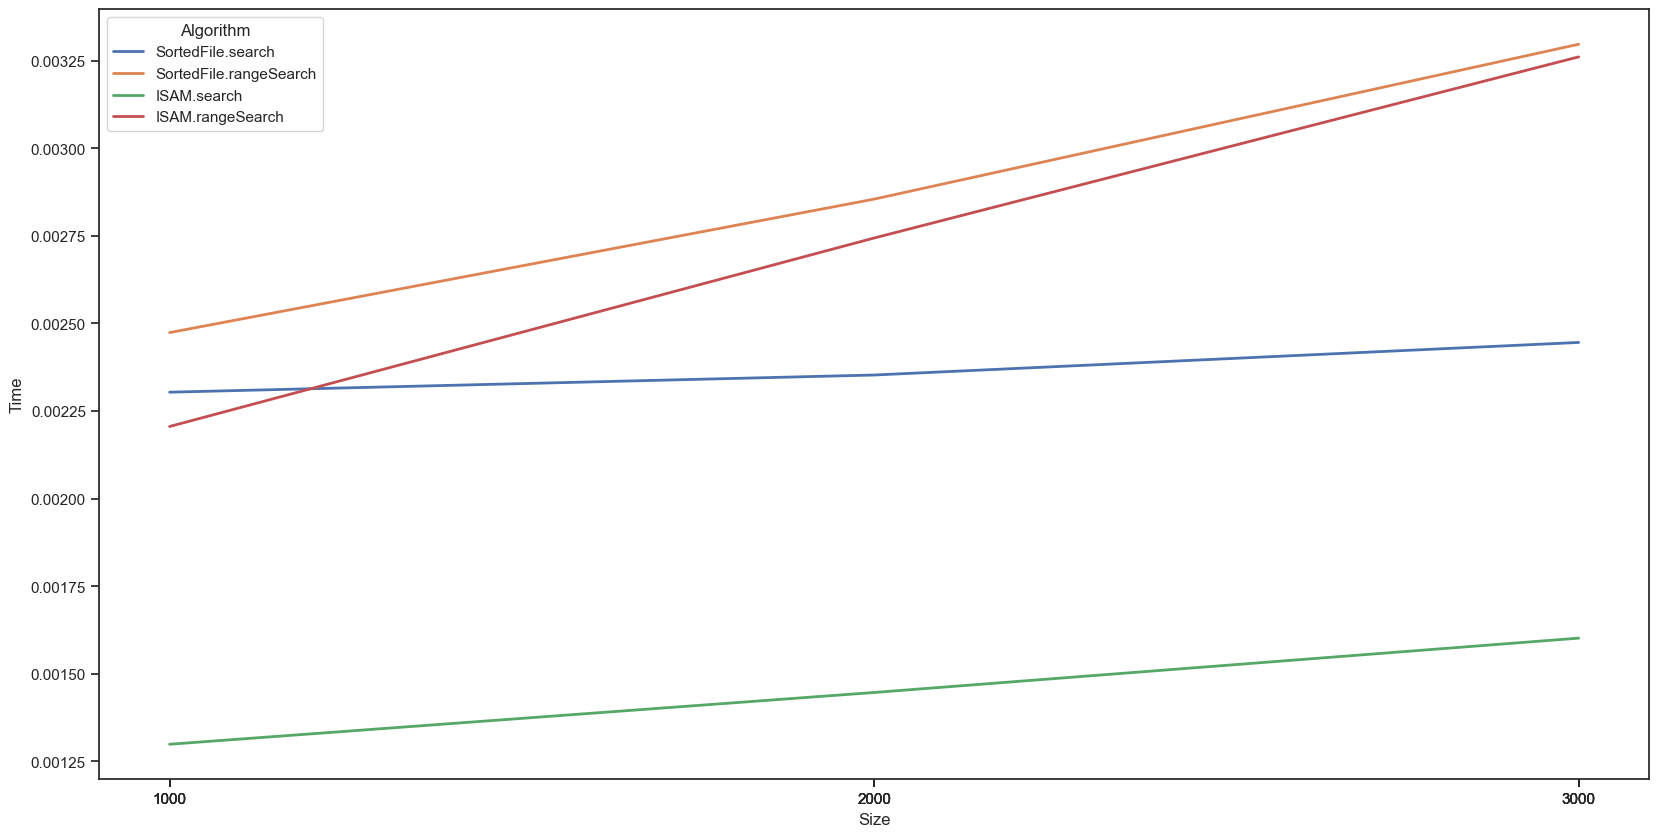

<Figure size 2000x1000 with 0 Axes>

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_dict(mapSizeToTime, orient='index', columns=['Time'])
#df = df[df.index.str.contains("scan")]
df['Algorithm'] = [i.split("##")[0] for i in df.index]
df['Size'] = [int(i.split("##")[1]) for i in df.index]

#Defines font size and line width
sns.set(font_scale=1, style="ticks", rc={"lines.linewidth": 2})

#Defines plot size
plt.rcParams['figure.figsize'] = [20, 10]

chart = sns.lineplot(x='Size', y='Time', hue='Algorithm', data=df)

#plt.yscale('log')
fig = plt.figure()
chart.set(xticks=[i for i in df.Size])
plt.show()